In [6]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd())) 
from src.load_dataset import load_dataset
from src.train_cnn import build_model
from src.predict_emotion import predict_emotion
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [7]:
train_data, val_data = load_dataset()
print("Dataset classes:", train_data.dataset.classes)

Path to dataset files: /Users/myeoh/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1
Train batches: 28821
Validation batches: 7066
Dataset classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------------------------------
# Code adapted from PyTorch CIFAR-10 tutorial: 
# https://pytorch.org/tutorials/downloads/cifar10_tutorial.py
# ----------------------------------------------------------------------
net = build_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

# Early stopping
best_val_acc = 0
patience_counter = 0
patience = 20

# helper function
def calculate_accuracy(data_loader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_data)
    train_loss.append(epoch_loss)
    
    train_acc = calculate_accuracy(train_data, net)
    train_accuracy.append(train_acc)
    print(f'Accuracy on training set: {train_acc:.2f} %')

    test_acc = calculate_accuracy(val_data, net)
    test_accuracy.append(test_acc)
    print(f'Accuracy on test set: {test_acc:.2f} %')
    
    # Learning rate scheduling and early stopping
    scheduler.step(epoch_loss)
    
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        patience_counter = 0
        # Save best model
        project_root = os.path.dirname(os.getcwd())
        os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
        save_path = os.path.join(project_root, "models", "emotion_net_best.pth")
        torch.save(net.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break


print('Finished Training')
print('Best validation accuracy:', best_val_acc)

# Save model
project_root = os.path.dirname(os.getcwd())
os.makedirs(os.path.join(project_root, "models"), exist_ok=True)
save_path = os.path.join(project_root, "models", "emotion_net.pth")
torch.save(net.state_dict(), save_path)
print(f"Saved model to {save_path}")

Accuracy on training set: 32.85 %
Accuracy on test set: 35.69 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 38.00 %
Accuracy on test set: 40.94 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 39.79 %
Accuracy on test set: 43.42 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 42.65 %
Accuracy on test set: 45.49 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 44.47 %
Accuracy on test set: 48.08 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 45.14 %
Accuracy on test set: 48.53 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotion_net_best.pth
Accuracy on training set: 46.37 %
Accuracy on test set: 49.72 %
Saved best model to /Users/myeoh/ECS174-FinalProject/models/emotio

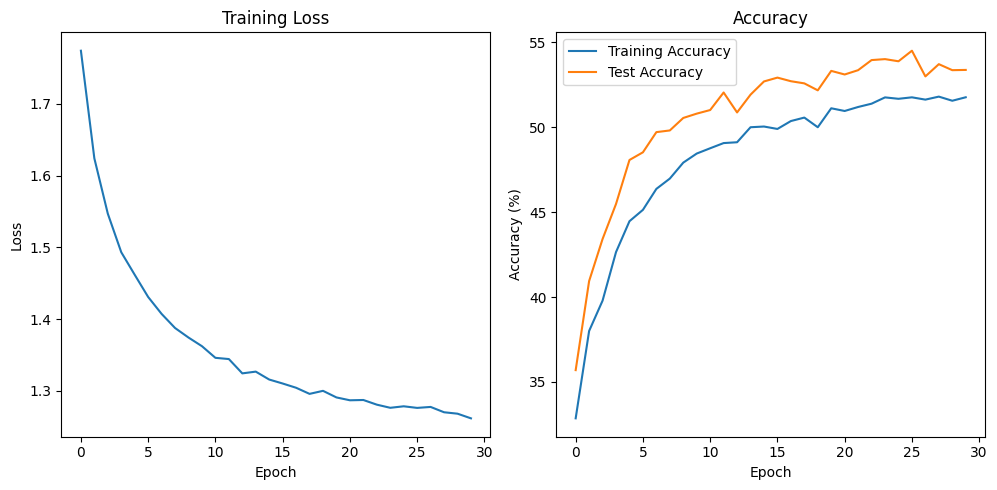

In [17]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

fear.jpg: surprise (0.489)
disgust.jpg: sad (0.313)
surprise.jpg: surprise (0.793)
happy.jpg: happy (0.870)
sad.jpg: sad (0.352)


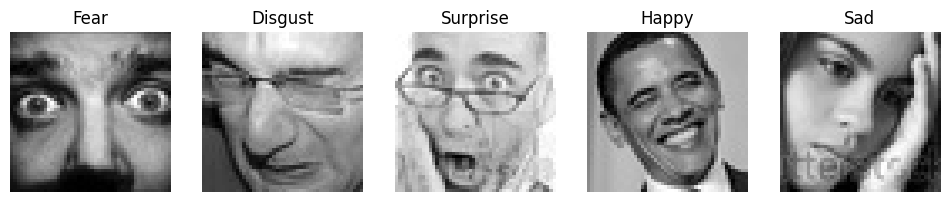

In [18]:
#test images

fig, axes = plt.subplots(1, 5, figsize=(12, 6))

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

for i, img_name in enumerate(['fear.jpg', 'disgust.jpg', 'surprise.jpg', 'happy.jpg', 'sad.jpg']):
    image = Image.open(img_name).convert('L')
    image_tensor = transform(image).squeeze(0)
    
    axes[i].imshow(image_tensor, cmap='gray')
    axes[i].set_title(img_name.split('.')[0].capitalize())
    axes[i].axis('off')
    
    result = predict_emotion(image_tensor, model_path='../models/emotion_net.pth')
    print(f"{img_name}: {result['emotion']} ({result['confidence']:.3f})")

plt.show()


Classification Report:
              precision    recall  f1-score   support

       angry      0.512     0.405     0.452       960
     disgust      0.000     0.000     0.000       111
        fear      0.478     0.196     0.279      1018
       happy      0.768     0.848     0.806      1825
     neutral      0.470     0.644     0.543      1216
         sad      0.437     0.522     0.476      1139
    surprise      0.689     0.734     0.711       797

    accuracy                          0.580      7066
   macro avg      0.479     0.478     0.467      7066
weighted avg      0.566     0.580     0.560      7066



/Users/myeoh/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/myeoh/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/myeoh/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


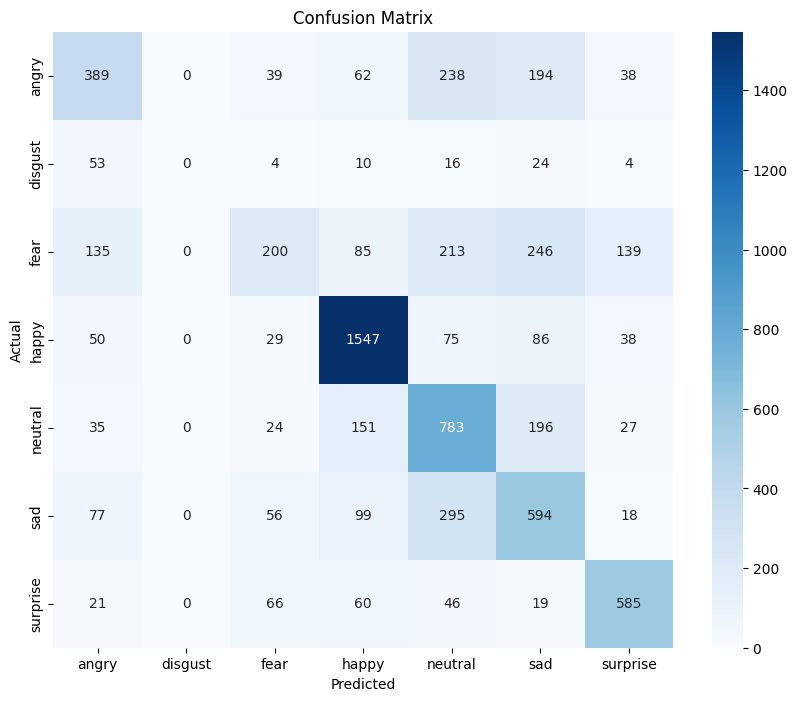

angry: 40.5% accuracy
disgust: 0.0% accuracy
fear: 19.6% accuracy
happy: 84.8% accuracy
neutral: 64.4% accuracy
sad: 52.2% accuracy
surprise: 73.4% accuracy


In [ ]:
# Evaluation: Classification Report and Confusion Matrix

# Load best model
net = build_model()
net.load_state_dict(torch.load('../models/emotion_net_best.pth', map_location='cpu'))
net.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in val_data:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names, digits=3))

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class accuracy
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i, :].sum() * 100
    print(f"{class_name}: {class_accuracy:.1f}% accuracy")
